# The gate will be optimised for a maximum split allocation, the gate time and the auxiliary qubit detuning.

In [1]:
from NotebookLib import *
import DiagSimulations
simulations  = reload(DiagSimulations)
with HiddenPrints():
    sim = simulations.Simulation('O-x-O')

import multiprocessing as mp

/home/yorgos/.local/lib/python3.8/site-packages/qutip/__init__.py:91: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.14.
  warnings.warn(
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


# Run Optimization of Simulations

In [1]:
gamma_val = sim.parameters['gamma']

# Global Parameters 
kSweep = [0.995]
CSweep = [20,25,30]
SplitSweep = [3,5,10]

# Optimization Accuracy  --- Give odd numbers
DeNum = 21
DENum = 20
tgNum = 21

SplitSweep = [spl*gamma_val for spl in SplitSweep]
AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep]

TotalParamElems = NumElemsInList(AllParams)
CurrentNumberOfSimulations = 1
for (k, C_val , MaxSplit) in AllParams:
    progressBar(CurrentNumberOfSimulations, TotalParamElems, barLength = 60)
    CurrentNumberOfSimulations +=1
    
    c_val = k/ (4-4*k)
    # Optimization Parameters  --- Give odd numbers
    # De
    DeSweep = np.linspace(0,MaxSplit , num = DeNum)
    # DE
    
    DESweep = np.linspace(0.1 , 2 , num = DENum) * np.sqrt(C_val)/gamma_val
    # GateTime
    
    tgSweep = np.linspace(0.90,1.10 , num = tgNum)

    ParamsSweep = [DeSweep ,DESweep,tgSweep ]
    ResultsShape = tuple([np.shape(param)[0] for param in ParamsSweep])

    Psucc = np.zeros(ResultsShape)
    Fidelity =  np.zeros(ResultsShape)
    GateTime =  np.zeros(ResultsShape)

    
    sim.ObtainGatePerformanceAnalyticallyC(C_val,c_val)
    gate_time_c = sim.GateTimeC
    p_succ_c = sim.PSuccessC
    fidelity_c = sim.StateFidelityC

    def simulation_process(De_val,DE_val,tgRatio ):
        De0_val =  De_val - MaxSplit
        
        ii = np.where( DeSweep == De_val)[0][0]
        jj = np.where( DESweep == DE_val)[0][0]
        kk = np.where( tgSweep == tgRatio)[0][0]
        index = (ii , jj , kk)

        gate_time = sg.real(gate_time_c.subs( C=C_val, De=De_val, De0=De0_val, DE=DE_val, c=c_val,tgr = tgRatio ))
        p_success = sg.real(p_succ_c.subs( C=C_val, De=De_val, De0=De0_val, DE=DE_val, c=c_val, tgr = tgRatio,tgs=gate_time))
        try:    
            fidelity = sg.real(fidelity_c.subs( \
                C=C_val, De=De_val, De0=De0_val, DE=DE_val, c=c_val,tgr = tgRatio,tgs=gate_time,pss=p_success ))
        except ValueError:
            fidelity = 0
        
        return gate_time , p_success , fidelity , index

    pool = mp.Pool()
    all_sweeps = product(DeSweep,DESweep,tgSweep)
    for (tg, ps,fid, index) in pool.starmap(simulation_process,all_sweeps):
        GateTime[index] = tg
        Psucc[index] = ps
        Fidelity[index] = fid
   
    Directory = f'OptimizationResults/ResC{C_val}_k{k}_Spl{MaxSplit}_e{DeNum}_E{DENum}_t{tgNum}'
    if not os.path.exists(Directory):
        os.makedirs(Directory)
    np.save(Directory+f'/Fidelity',Fidelity)
    np.save(Directory+f'/GateTime',GateTime)
    np.save(Directory+f'/Psucc',Psucc)

NameError: name 'sim' is not defined

# Plotting

<>:26: DeprecationWarning: invalid escape sequence \%
<>:27: DeprecationWarning: invalid escape sequence \%
<>:39: DeprecationWarning: invalid escape sequence \L
<>:39: DeprecationWarning: invalid escape sequence \D
<>:26: DeprecationWarning: invalid escape sequence \%
<>:27: DeprecationWarning: invalid escape sequence \%
<>:39: DeprecationWarning: invalid escape sequence \L
<>:39: DeprecationWarning: invalid escape sequence \D
<ipython-input-89-cda25e7cd12f>:26: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'\%$\n'
<ipython-input-89-cda25e7cd12f>:27: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=2))+'\%$\n'
<ipython-input-89-cda25e7cd12f>:39: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n $(\Delta

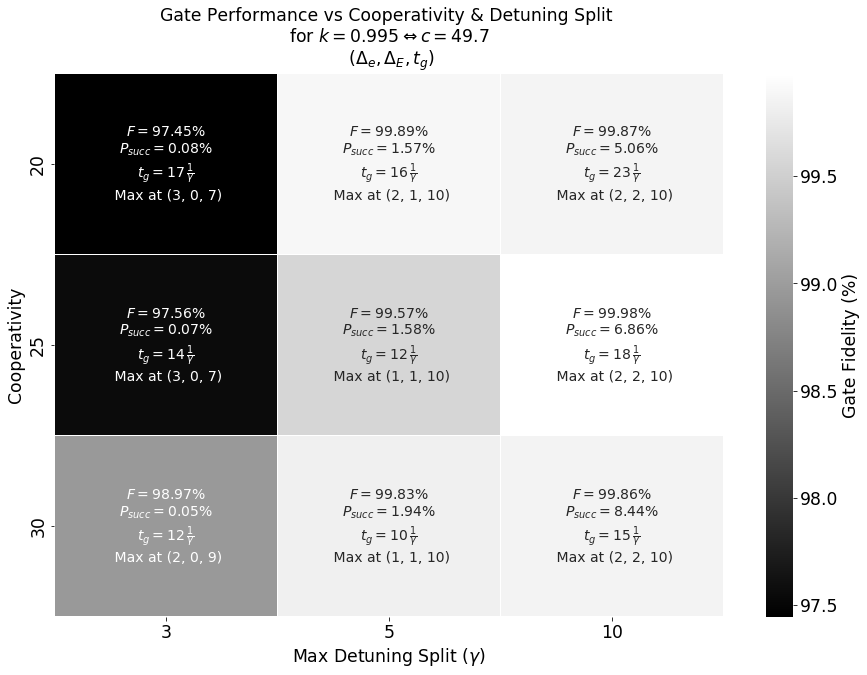

In [89]:
#Complete optimization for Fidelity
import seaborn as sns
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)
'''
CSweep = [25,50,100]

SplitSweep = [3,5,10]

DeNum = 11
DENum = 11
tgNum = 11'''

AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
FidelityPlot = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        DataDirectory = f'OptimizationResults/ResC{c}_k{kPlot}_Spl{spl}_e{DeNum}_E{DENum}_t{tgNum}/'
        GateTimeData = np.load(DataDirectory+"GateTime.npy")
        FidelityData = np.load(DataDirectory+"Fidelity.npy")
        PsuccData = np.load(DataDirectory+"Psucc.npy")

        argm = ArgMax(FidelityData) #-(1-FidelityData)*(1-PsuccData)
        FidelityPlot[i][j] = FidelityData[argm]

        AllLabels[i][j] += '$F='+ str(np.round(FidelityData[argm]*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(PsuccData[argm]*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$t_g='+ str(int(GateTimeData[argm]))+r' \,\frac{1}{\gamma}$'
        AllLabels[i][j] += f'\n Max at {argm}'
        


fig, ax = plt.subplots()


ax = sns.heatmap(FidelityPlot*100,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Gate Fidelity (%)'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n $(\Delta_e,\Delta_E,t_g)$')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg')

In [149]:
from scipy.optimize import minimize
import sage.all as sg
sg.var('De','tgr','DE','tgs')
C_val = 30
c_val = cPlot
sim.ObtainGatePerformanceAnalyticallyC(C_val,c_val)

GateTimeS = sim.GateTimeC.subs(De0=De-10).subs(De=DeSweep[2],DE=DESweep[2],tgr=tgSweep[10])
PsuccS    = sim.PSuccessC.subs(De0=De-10,tgs=GateTimeS) 
FidelityS = sim.StateFidelityC.subs(De0=De-10,tgs=GateTimeS, pss=PsuccS).subs(De=DeSweep[2],DE=DESweep[2],tgr=tgSweep[10])
print(FidelityS)
print(GateTimeS)

0.9985519340302554
15.114866616273867


In [132]:
sg.var('De','tgr','DE','tgs')
C_val = 30
c_val = cPlot
sim.ObtainGatePerformanceAnalyticallyC(C_val,c_val)

GateTimeS = sim.GateTimeC.subs(De0=De-10)
PsuccS    = sim.PSuccessC.subs(De0=De-10,tgs=GateTimeS) 
FidelityS = sim.StateFidelityC.subs(De0=De-10,tgs=GateTimeS, pss=PsuccS)

In [135]:
fid_fun = FidelityS.function(tgr,De,DE)

def fidel(params):
    t, de, dE = params
    try:
        return 1-fid_fun(t,de,dE)
    except:
        return 1 

psuc_fun = PsuccS.function(tgr,De,DE)
def psucc(params):
    t, de, dE = params
    return (float(sg.real(psuc_fun(t,de,dE))))



In [140]:
result = minimize(fidel,[ DeSweep[2],DESweep[2],tgSweep[10] ], method = 'Nelder-Mead')

In [144]:
print(f'initial: {[ DeSweep[2],DESweep[2],tgSweep[10] ]}')
print(f'final: {result.x}')

initial: [1.0, 1.6431676725154982, 1.0]
final: [0.99999273 0.9506143  1.58440665]


In [142]:
fidel(result.x)

8.595435474489932e-11

In [143]:
psucc(result.x)

0.07739918069579933

In [148]:
fid_fun(result.x[0]*0.9,result.x[1]*0.9,result.x[2]*0.9)

0.9817845010690076